# Trade
- Swing trading/long-term trading
    - Exposed to overnight risk (close price previous day might not equal to open 
    price next day if there are major events happening between market closure and
    market open).
- Assume I already have which day to long, which day to short
- Conduct post-trade analysis
- Refine risk management techniques (Comparing starting on 2023-12-22)
    - Boeing: Main character in the events
        - Stock -18.61%

    - Direct competitors
        - Airbus (EPA: AIR): Boeing's primary competitor in commercial aircraft manufacturing
            - Stock +5.93%
        - Lockhead Martin (LMT): More focused on defense but also compete in aerospace
    - Suppliers
        - General Electric (GE): Supplies engines for Boeing aircraft
            - Have presence in aviation, healthcare, power, renewable energy
            - Doesn't seem to be affected
            - Can also supply engines to other aircraft manufacturers (effect on
            stock price is complicated)
    - Customers
        - Alaska Airlines (ALK): Main airline involved
            - Stock -11.73%
        - American Airlines (UAL - NasdaqGS)
            - Stock -4.91%
        - Delta Air Lines (DAL)
            - -11.73%
        - Southwest Airlines
- Trading timing (NYSE) vs news timing
    - The news was updated on January 18, 2024, at 4:36 AM GMT+8, which translates to January 17, 2024, at 3:36 PM Eastern Time (since GMT+8 is 13 hours ahead of Eastern Time). Since the NYSE closes at 4:00 PM ET, this news would have come out just before the market close.
    - Difference stock exchanges might operate at different timings also
- No training and validation - straight go to validation (backtesting)


# Set Up

In [39]:
import os
import ast
import requests
import logging

import yfinance as yf
import pandas as pd
import numpy as np

import finnhub
from dotenv import load_dotenv
from pathlib import Path    
import sys
import time
import itertools

import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import typing

sys.path.append('../') # Change the python path at runtime

# Self-created modules
from src.utils import path as path_yq
from src.backtesting import Backtest, Strategy


In [2]:
np.random.seed(7)
load_dotenv()
POLYGON_API_KEY = os.environ.get('POLYGON_API_KEY')

BT_START_DATE = '2023-11-01'
BT_START_STR = '20231101'
BT_END_DATE = '2024-01-31'
BT_END_STR = '20240131'

cur_dir = Path.cwd()
root_dir = path_yq.get_root_dir(cur_dir)

logging.basicConfig(filename=Path.joinpath(root_dir, 'logs', 'trading_system.log'),
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.DEBUG)

stm_techs = ['stc', 'blob', 'sid', 'bert', 'finbert']
contents = ['cln_hdl', 'cln_smr', 'cln_news']
lemmas = ['', 'lemma']

# Fetch Tick Data

## Polygon

Polygon docs: https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to

- FIXME: The timings include those in pre-market hours
- The timestamp is in ms, not sec

Similar to download data codes
TODO: Assumption: assume other stocks share the same timezone

- The data is incomplete (not every minute)
24265	47739.0	217.6996	217.6800	217.7000	217.7000	217.6800	1705096560000	21	2024-01-12 21:56:00
24266	171.0	217.5423	217.5000	217.5000	217.5000	217.5000	1705096800000	5	2024-01-12 22:00:00

In [ ]:
url = f"https://api.polygon.io/v2/aggs/ticker/BA/range/1/minute/{BT_START_DATE}/{BT_END_DATE}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"

# Make the GET request
resp = requests.get(url)

In [ ]:
# Check if the request was successful
if resp.status_code == 200:
    # Convert the 'results' list to a DataFrame
    df = pd.DataFrame(resp.json().get('results'))

    # Rename the columns to more descriptive names
    column_mapping = {
        "v": "Volume",
        "vw": "VWAP",
        "o": "Open",
        "c": "Close",
        "h": "High",
        "l": "Low",
        "t": "Timestamp",
        "n": "Transactions"
        # Add more mappings as necessary
    }

    df.rename(columns=column_mapping, inplace=True)

    # Optionally, convert the 'Timestamp' column from Unix milliseconds to a datetime format
    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')

    # Display the updated DataFrame
    print(df)
else:
    # Handle errors (e.g., logging, raising an exception)
    print(f"Error fetching data: {resp.status_code}, {resp.text}")



In [ ]:
# Boeing open high low close data
raw_path = Path.joinpath(root_dir, 'data', 'raw', f'BA_OHLC_{BT_START_STR}_{BT_END_STR}.csv')
df.to_csv(raw_path, index=False)

## Yahoo (Outdated)

In [ ]:
# Define the ticker list
ticker_list = ['BA']

# Fetch the data
dl_data = yf.download(ticker_list, start=BT_START_DATE, end=BT_END_DATE) # Auto adjust is false

dl_data = pd.DataFrame(dl_data)
data = dl_data.drop(columns=['Close'], axis=1)
data = data.rename(columns={'Adj Close': 'Close'})
display(data.isna().sum(axis=0)) # Axis=0: along the indices, row-wise opertaion
# Gives the sum for rows in a column
data.index = pd.to_datetime(data.index)
data


In [ ]:
dates = pd.DataFrame(data.index.strftime('%Y-%m-%d'))
# dates.to_csv("trading_dates.csv", index=False)

In [ ]:
# After performing sentiment
stm_path = root_dir.joinpath('data', 'proc', 'boeing_stm_20231101_to_20240131.csv')
news = pd.read_csv(stm_path, index_col=False)
news2 = news[['datetime2', 'news_pol_blob']]
news2

news2.plot()
# # data['Sentiment'] = np.random.random(len(data)) * 2 - 1
# display(len(data))
# sentiment = np.array([0, -1, -0.8, 0, 0, 0]) # Put -1 on 01-05 (Before the whole thing Boeing case appeared after market closed on 01-05 to prepare to trade for 01-08)
# data['Sentiment'] = sentiment
# display(data.tail(20))

In [ ]:
# Ensure datetime2 in news2 is in pandas datetime format
news2['datetime2'] = pd.to_datetime(news2['datetime2'])

# Assuming data.index is already a DatetimeIndex, no need to convert it again
# Just ensure it's sorted
data.sort_index(inplace=True)

# Function to find the closest previous date in data for each date in news2
def find_closest_previous_date(target_date, date_index):
    previous_dates = date_index[date_index <= target_date]
    if not previous_dates.empty:
        return previous_dates.max()
    else:
        return pd.NaT  # Return Not-A-Time (NaT) if no previous date is found

# Apply the function to each date in news2['datetime2']
closest_dates = news2['datetime2'].apply(lambda x: find_closest_previous_date(x, data.index))

# Add this closest date information to news2
news2['closest_date'] = closest_dates
news2

In [ ]:
# TODO: Need to think of how to combine the data (might have many neutral etc.)
# as_index will retain closest_date
news3 = news2.groupby('closest_date', as_index=False)['news_pol_blob'].mean().reset_index(drop=True) 
news3

In [ ]:
merged = pd.merge(data, news3, left_on='Date', right_on='closest_date', how='left')
merged

In [ ]:
# Clean for 2 lines only
merged2 = merged.dropna().reset_index(drop=True)
merged2

# Merge data

In [3]:

def convert_data(row):
    """
    A function from sentiment.ipynb.
    """
    try:
        # First, try to evaluate the row as a list
        evaluated = ast.literal_eval(row)
        # If the result is a list, return it directly
        if isinstance(evaluated, list):
            return evaluated
        # If not, it's already the correct type (int, float, etc.)
        return evaluated
    except ValueError:
        # Handle the case where the row is not a valid Python literal
        # This could be a string that should not be converted
        return row
    except SyntaxError:
        # Handle syntax errors which might occur if ast.literal_eval can't parse the string
        return row
    except Exception as e:
        print(f'Exception: {e}')
        return row

score_path = root_dir.joinpath('data', 'proc', f'BA_score_{BT_START_STR}_{BT_END_STR}.csv') 
df9 = pd.read_csv(score_path, index_col=False)

# Apply the conversion function to each specified column
for col in df9.columns:
    df9[col] = df9[col].apply(convert_data)
df9['datetime2'] = pd.to_datetime(df9['datetime2'])

# print(df8.equals(df7))
# print(type(df8['datetime2'][0]))

In [4]:
# Fetch and sort tick data
# Boeing open high low close data
raw_path = Path.joinpath(root_dir, 'data', 'raw', f'BA_OHLC_{BT_START_STR}_{BT_END_STR}.csv')
tick = pd.read_csv(raw_path, index_col=False)
tick['Datetime'] = pd.to_datetime(tick['Datetime'])
tick = tick.sort_values(by='Datetime')

# Make sure the tick data is within backtest date range
tick = tick[(tick['Datetime'] >= BT_START_DATE) & (tick['Datetime'] <= BT_END_DATE)]
tick

,Volume,VWAP,Open,Close,High,Low,Timestamp,Transactions,Datetime
0,991.0,186.6991,186.6200,186.8000,186.8000,186.6200,1698829200000,31,2023-11-01 09:00:00
1,410.0,186.8187,186.8200,186.8200,186.8200,186.8200,1698829560000,5,2023-11-01 09:06:00
2,1289.0,187.6589,187.5900,187.7000,187.7000,187.5900,1698830040000,29,2023-11-01 09:14:00
3,535.0,188.1637,187.8400,187.9600,187.9600,187.8400,1698830100000,34,2023-11-01 09:15:00
4,442.0,188.8297,188.7900,188.7900,188.7900,188.7900,1698830160000,27,2023-11-01 09:16:00
...,...,...,...,...,...,...,...,...,...
31393,1009.0,199.7495,199.7500,199.7500,199.7500,199.7500,1706658600000,7,2024-01-30 23:50:00
31394,250.0,199.6644,199.6500,199.6500,199.6500,199.6500,1706658720000,4,2024-01-30 23:52:00
31395,315.0,199.7283,199.7369,199.7369,199.7369,199.7369,1706658960000,11,2024-01-30 23:56:00
31396,503.0,199.7896,199.7999,199.7999,199.7999,199.7999,1706659080000,6,2024-01-30 23:58:00


In [5]:
# Assuming data.index is already a DatetimeIndex, no need to convert it again
df9['datetime2'] = pd.to_datetime(df9['datetime2'])
tick['Datetime'] = pd.to_datetime(tick['Datetime'])

# Make sure to sort first
df9 = df9.sort_values(by='datetime2')
tick = tick.sort_values(by='Datetime')

# Function to find the closest previous date in tick for each date in news2
def find_closest_prev_date(target_date, date_col):
    # The information gotten at this time point can only be used in the next time point
    prev_dates = date_col[date_col <= target_date] 
    if not prev_dates.empty:
        return prev_dates.max()
    else:
        # Can happen when the news is earlier than all the tick data
        print(f"WARNING. Previous date not found for {target_date}")
        print(date_col)
        return pd.NaT  # Return Not-A-Time (NaT) if no previous date is found

# Apply the function to each date in news2['datetime2']
closest_dates = df9['datetime2'].apply(lambda x: find_closest_prev_date(x, tick['Datetime']))

# Add this closest date information to news2
df9['closest_date'] = closest_dates
df9.sort_values(by='datetime2')
df9.reset_index(inplace=True, drop=True)
df9

WARNING. Previous date not found for 2023-11-01 05:39:51
0       2023-11-01 09:00:00
1       2023-11-01 09:06:00
2       2023-11-01 09:14:00
3       2023-11-01 09:15:00
4       2023-11-01 09:16:00
                ...        
31393   2024-01-30 23:50:00
31394   2024-01-30 23:52:00
31395   2024-01-30 23:56:00
31396   2024-01-30 23:58:00
31397   2024-01-31 00:00:00
Name: Datetime, Length: 31398, dtype: datetime64[ns]


,id,datetime2,cln_hdl,cln_smr,cln_news,cln_hdl_lemma,cln_smr_lemma,cln_news_lemma,cln_hdl_pol_blob,cln_smr_pol_blob,...,cln_hdl_lemma_pol_bert_score,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score,closest_date
0,123559928,2023-11-01 05:39:51,"[Ford, GM bumped to buy Boeing gets 2 upgrades...",[Goldman Sachs upgraded Simon Property Group (...,[Investing.com — Here is your Pro Recap of the...,"[Ford , GM bumped buy Boeing get 2 upgrade : 4...",[Goldman Sachs upgraded Simon Property Group (...,[Investing.com — Pro Recap biggest analyst pic...,[0.0],[0.0],...,0.727060,-0.689266,-0.340141,0.894530,0.549459,0.360264,0.641842,0.836147,0.400344,NaT
1,123544219,2023-11-01 11:39:06,[UPDATE 2-Spirit Aero cuts 737 fuselage delive...,[Spirit AeroSystems on Wednesday announced $10...,"[(Adjusts shares in paragraph 5, adds Airbus c...",[UPDATE 2-Spirit Aero cut 737 fuselage deliver...,[Spirit AeroSystems Wednesday announced $ 101 ...,"[( Adjusts share paragraph 5 , add Airbus comm...",[0.0],"[0.0, 0.0625, 0.0]",...,0.142053,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931,2023-11-01 11:39:00
2,123566505,2023-11-01 13:30:29,"[Compared to Estimates, Spirit Aerosystems (SP...",[Although the revenue and EPS for Spirit Aeros...,"[For the quarter ended September 2023, Spirit ...","[Compared Estimates , Spirit Aerosystems ( SPR...",[Although revenue EPS Spirit Aerosystems ( SPR...,"[quarter ended September 2023 , Spirit Aerosys...",[0.0],[0.15],...,0.174489,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006,2023-11-01 13:30:00
3,123545059,2023-11-01 14:21:57,[Morning Brew: AMDs Q4 Guidance Weighs on Stoc...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Morning Brew : AMDs Q4 Guidance Weighs Stock ...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[-0.3],"[0.1527777777777778, 0.22727272727272727, -0.06]",...,-0.744470,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774,2023-11-01 14:21:00
4,123567205,2023-11-01 22:24:31,[UPDATE 1-US Air Force blows up Minuteman III ...,[The U.S. Air Force said on Wednesday it had b...,[Nov 1 (Reuters) - The U.S. Air Force said on ...,[UPDATE 1-US Air Force blow Minuteman III test...,[U.S. Air Force said Wednesday blown Minuteman...,[Nov 1 ( Reuters ) - U.S. Air Force said Wedne...,[0.0],"[-0.4, -0.25, 0.0]",...,-0.733265,-0.253360,0.317687,-0.892588,-0.872526,-0.066805,0.000000,0.000000,-0.047870,2023-11-01 22:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,125415682,2024-01-30 21:10:56,[Boeing Seen Narrowing Q4 Loss Amid 737 Max Gr...,[Dow Jones giant Boeing reports Q4 results ear...,[Dow Jones giant Boeing reports Q4 results ear...,[Boeing Seen Narrowing Q4 Loss Amid 737 Max Gr...,[Dow Jones giant Boeing report Q4 result early...,[Dow Jones giant Boeing report Q4 result early...,[0.0],"[0.05, 0.1]",...,-0.737527,-0.239781,-0.239781,-0.965217,-0.952749,-0.952749,-0.965217,-0.944420,-0.944420,2024-01-30 21:09:00
547,125415680,2024-01-30 22:23:48,"[Hawaiian Airlines ekes out Q4 revenue beat, e...",[Hawaiian Holdings (HA) — the parent company o...,[Hawaiian Holdings (HA) — the parent company o...,"[Hawaiian Airlines ekes Q4 revenue beat , earn...",[Hawaiian Holdings ( HA ) — parent company Haw...,[Hawaiian Holdings ( HA ) — parent company Haw...,[0.0],"[-0.06666666666666667, -0.15555555555555559, 0...",...,-0.776986,-0.258785,-0.224460,-0.381478,-0.922368,-0.055458,-0.667220,-0.905073,0.281039,2024-01-30 22:21:00
548,125415679,2024-01-30 22:39:00,"[Boeings Earnings Are Coming., Investors Are W...",[The list of points to watch when the jet make...,[The number of watch items in Boeings fourth-q...,"[Boein

In [6]:
# Find the difference between datetime2 and closest_date to reduce overnight trading risks,
# or risks caused by lack of tick data
df9['datetime_diff'] = df9['datetime2'] - df9['closest_date']
# Check if there is any negative difference
print(np.sum(df9['datetime_diff'] < pd.Timedelta(0)))

mask = df9['datetime_diff'] >= pd.Timedelta(5, unit='m')
df9 = df9[~mask]

0


In [7]:
# Drop the NaT in find previous closest dates
def drop_na(df):
    # Drop all the news_content with na
    print(f"Before dropping na: {df.isna().sum().sum()}")
    df1 = df.dropna()
    df1.reset_index(inplace=True, drop=True)
    print(f"After dropping na: {df.isna().sum().sum()}")
    return df1



In [8]:
drop_na(df9).head()

Before dropping na: 2
After dropping na: 2


,id,datetime2,cln_hdl,cln_smr,cln_news,cln_hdl_lemma,cln_smr_lemma,cln_news_lemma,cln_hdl_pol_blob,cln_smr_pol_blob,...,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score,closest_date,datetime_diff
0,123544219,2023-11-01 11:39:06,[UPDATE 2-Spirit Aero cuts 737 fuselage delive...,[Spirit AeroSystems on Wednesday announced $10...,"[(Adjusts shares in paragraph 5, adds Airbus c...",[UPDATE 2-Spirit Aero cut 737 fuselage deliver...,[Spirit AeroSystems Wednesday announced $ 101 ...,"[( Adjusts share paragraph 5 , add Airbus comm...",[0.0],"[0.0, 0.0625, 0.0]",...,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931,2023-11-01 11:39:00,0 days 00:00:06
1,123566505,2023-11-01 13:30:29,"[Compared to Estimates, Spirit Aerosystems (SP...",[Although the revenue and EPS for Spirit Aeros...,"[For the quarter ended September 2023, Spirit ...","[Compared Estimates , Spirit Aerosystems ( SPR...",[Although revenue EPS Spirit Aerosystems ( SPR...,"[quarter ended September 2023 , Spirit Aerosys...",[0.0],[0.15],...,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006,2023-11-01 13:30:00,0 days 00:00:29
2,123545059,2023-11-01 14:21:57,[Morning Brew: AMDs Q4 Guidance Weighs on Stoc...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Morning Brew : AMDs Q4 Guidance Weighs Stock ...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[-0.3],"[0.1527777777777778, 0.22727272727272727, -0.06]",...,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774,2023-11-01 14:21:00,0 days 00:00:57
3,123567203,2023-11-01 22:48:19,[Boeing says cyber incident hit parts business...,"[WASHINGTON (Reuters) -Boeing, one of the worl...","[WASHINGTON (Reuters) -Boeing, one of the worl...",[Boeing say cyber incident hit part business r...,"[WASHINGTON ( Reuters ) -Boeing , one world la...","[WASHINGTON ( Reuters ) -Boeing , one world la...",[0.0],"[0.0, 0.21666666666666667, -0.4]",...,-0.816141,-0.514869,-0.933888,-0.852436,-0.545566,-0.918345,-0.739639,-0.677498,2023-11-01 22:46:00,0 days 00:02:19
4,123598129,2023-11-02 12:11:45,[Aerospace supplier Howmet lifts forecast as j...,[Howmet Aerospace on Thursday raised its annua...,[Nov 2 (Reuters) - Howmet Aerospace on Thursda...,[Aerospace supplier Howmet lift forecast jet p...,[Howmet Aerospace Thursday raised annual profi...,[Nov 2 ( Reuters ) - Howmet Aerospace Thursday...,[0.0],"[0.25, 0.0, 0.0]",...,0.660526,-0.097193,0.644744,0.842242,0.913904,0.000000,0.851312,0.883437,2023-11-02 12:09:00,0 days 00:02:45


Check whether there are 30 columns of scores

In [ ]:
df9.columns

## Merge Scores between Trading Periods

In [9]:
df_list = []

for stm_tech in stm_techs:
    for lemma in lemmas:
        for content in contents:
            if lemma:
                col_name = f'{content}_{lemma}_pol_{stm_tech}_score'

            else:
                col_name = f'{content}_pol_{stm_tech}_score'
            tmp = df9.groupby('closest_date', as_index=False)[col_name].mean().reset_index(drop=True) 
            df_list.append(tmp)
            # display(tmp)
# print(df_list)

# # Assumes df_list has at least two elements
# merged = df_list[0]
# for i in range(1, len(df_list)):
#     merged = pd.merge(left=merged, right=df_list[i], on='closest_date', how='inner')
# merged

from functools import reduce
# A simpler implementation
merged = reduce(lambda left, right: pd.merge(left, right, on='closest_date', how='inner'), df_list)
merged

,closest_date,cln_hdl_pol_stc_score,cln_smr_pol_stc_score,cln_news_pol_stc_score,cln_hdl_lemma_pol_stc_score,cln_smr_lemma_pol_stc_score,cln_news_lemma_pol_stc_score,cln_hdl_pol_blob_score,cln_smr_pol_blob_score,cln_news_pol_blob_score,...,cln_news_pol_bert_score,cln_hdl_lemma_pol_bert_score,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score
0,2023-11-01 11:39:00,0.830,0.176667,0.462500,0.830,0.716667,0.563750,0.0,0.062500,0.114889,...,-0.408932,0.142053,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931
1,2023-11-01 13:30:00,0.430,0.610000,0.519259,0.430,0.610000,0.520000,0.0,0.150000,0.006184,...,-0.099371,0.174489,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006
2,2023-11-01 14:21:00,-0.330,0.653333,0.452609,-0.330,0.610000,0.445217,-0.3,0.106684,0.110974,...,-0.148375,-0.744470,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774
3,2023-11-01 22:46:00,-0.720,-0.263333,-0.104737,-0.720,-0.263333,0.066842,0.0,-0.091667,-0.049907,...,-0.419641,-0.891580,-0.816141,-0.514869,-0.933888,-0.852436,-0.545566,-0.918345,-0.739639,-0.677498
4,2023-11-02 12:09:00,0.610,0.653333,0.561111,0.610,0.656667,0.573333,0.0,0.250000,0.186364,...,-0.184024,0.694625,0.660526,-0.097193,0.644744,0.842242,0.913904,0.000000,0.851312,0.883437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2024-01-30 21:09:00,-0.750,0.445000,0.445000,-0.750,0.445000,0.445000,0.0,0.075000,0.075000,...,-0.387261,-0.737527,-0.239781,-0.239781,-0.965217,-0.952749,-0.952749,-0.965217,-0.944420,-0.944420
393,2024-01-30 22:21:00,0.540,0.432500,0.434211,0.540,0.455000,0.305789,0.0,0.031684,0.144500,...,-0.182459,-0.776986,-0.258785,-0.224460,-0.381478,-0.922368,-0.055458,-0.667220,-0.905073,0.281039
394,2024-01-30 22:38:00,0.525,-0.500000,-0.400000,0.525,0.640000,-0.400000,0.0,0.225000,-0.050000,...,0.000000,0.698278,0.720234,0.151111,0.856519,0.000000,0.000000,0.730035,0.000000,0.000000
395,2024-01-30 23:03:00,0.515,-0.192500,0.225789,0.515,-0.207500,0.181504,0.0,-0.141859,0.066913,...,-0.176781,-0.262539,-0.442463,-0.278902,0.000000,-0.928406,-0.508453,0.000000,-0.912366,-0.404513


## Merge Tick Data and Scores

In [10]:
merged2 = pd.merge(left=tick, right=merged, left_on='Datetime', right_on='closest_date', how='left')
merged2.reset_index(inplace=True, drop=True)

In [11]:
merge_path = root_dir.joinpath('data', 'proc', f'BA_merged_{BT_START_STR}_{BT_END_STR}.csv') # TODO: Change dates
merged2.to_csv(merge_path, index=False)

## Simple Post-Trade Analysis

In [ ]:
merged2[merged2.index == 1873]

In [ ]:
# Choose col_name to describe
merged2[col_name].describe()

In [ ]:
# Post-trade analysis
merged2[merged2['Datetime'] >= pd.to_datetime('2023-11-01 11:39:00')]



# Backtesting
- Pros
    - Test single strategy
    - Have optimizer, graphs
- Cons
    - Cannot trade multiple assets FIXME: not applicable to portfolio
    - Does not trade fractional shares
https://kernc.github.io/backtesting.py/#example


- Other backtesting framework: backtrader, zipline - both can do multi-asset trading
- Backtrader works with Pandas DataFrames, CSV, and real-time data feeds from Interactive Brokers, Oanda, and Visual Chart. 
- 2% rule: https://www.investopedia.com/terms/t/two-percent-rule.asp#:~:text=What%20Is%20the%202%25%20Rule,capital%20on%20any%20single%20trade.
- Try to have less than 10% of drawdown: https://www.quora.com/How-do-I-use-the-never-risk-more-than-2-rule-in-Forex-trading


Hypothesis
- Takes in a df from start to end, with all the ticker data (including those NA for sentiment)
- Enters trade at 549 (My information should backfill)
548	308.0	247.7006	247.7000	247.7000	247.7000	247.7000	1704291540000	8	2024-01-03 14:19:00	2024-01-03 14:19:00	0.156808
549	264.0	247.6105	247.6000	247.6000	247.6000	247.6000	1704291780000	9	2024-01-03 14:23:00	NaT	NaN
550	1157.0	247.5724	247.6000	247.5031	247.6001	247.5031	1704291840000	49	2024-01-03 14:24:00	NaT	NaN
- I can compare the results between lemmatization or not, and fix other variables constant
- I can compare the results between different content and fix others constant



## Strategy

In [12]:
TP_PCT = 0.02
SL_PCT = 0.006
RISK_PER_TRADE = 0.5


class SimpleStmStrat(Strategy):
    """
    Use a proportional amount of cash to trade with the sentiment score indicator.
    """
    # Strategy class should define parameters as class variables before they can be optimized or run with.
    col = None

    # Add the parameters in init
    def __init__(self, broker, data, **kwargs):
        super().__init__(broker, data, **kwargs)  # Make sure the parent class can handle **kwargs appropriately
        self.col = kwargs.get('col', self.col)

    # Initialize additional indicators here if needed
    def init(self):
        # self.trade_size = 40 # This times the next open price cannot exceed equity
        self.tp_pct = TP_PCT
        self.sl_pct = SL_PCT
        self.risk_per_trade = RISK_PER_TRADE # Maximum of the portfolio on one trade

    def next(self):
        cur_stm = self.data[self.col][-1]
        # print(self.data['closest_date'][-1])
        cur_price = self.data['Close'][-1]

        # print(f"-----{self.data['Datetime'][-1]}-----")
        # trade_size = (0.5 * (abs(cur_stm) ** 2) + 0.5) * self.risk_per_trade

        # Can be around 15

        # Decision is made on the time point before entry 
        # Entry Bar is the index, entry price is the open price of the next time point
        # Not sure why exit price is not the open price at the exitBar?? Should be because of tp and sl

        trade_size = self.risk_per_trade 
        if (cur_stm > 0.2): # Many losses if I don't take
            # print(f"Buy: {self.data['closest_date'][-1]}")
            self.buy(size=trade_size, sl=(1 - self.sl_pct) * cur_price, tp=(1 + self.tp_pct) * cur_price)
            # If size is a value between 0 and 1, it is interpreted as a fraction of current available liquidity (cash plus Position.pl minus used margin). A value greater than or equal to 1 indicates an absolute number of units.

        elif cur_stm < -0.2:
            # print(f"Sell: {self.data['closest_date'][-1]}")
            self.sell(size=trade_size, sl=(1 + self.sl_pct) * cur_price, tp=(1 - self.tp_pct) * cur_price)
        else:
            pass
        # print(cur_stm)

class RandomStrat(Strategy):
    """
    A strategy that randomly trades for ttl_trade times, and if it trades,
    the probability of buy and sell is 0.5.
    """
    ttl_trade = 10
    # Add the parameters in init
    def __init__(self, broker, data, **kwargs):
        super().__init__(broker, data, **kwargs)  # Make sure the parent class can handle **kwargs appropriately
        self.ttl_trade = kwargs.get('ttl_trade', self.ttl_trade)
        self.trade_prob = self.ttl_trade / len(self.data)
        # print(f"Total number of data:{len(self.data)}")
        
    # Initialize additional indicators here if needed
    def init(self):
        self.tp_pct = TP_PCT
        self.sl_pct = SL_PCT
        self.risk_per_trade = RISK_PER_TRADE # Maximum of the portfolio on one trade

    def next(self):
        trade_size = self.risk_per_trade 
        cur_price = self.data['Close'][-1]
        trade_flag = np.random.rand() < self.trade_prob
        buy_flag = np.random.rand() > 0.5
        if (trade_flag and buy_flag): # Many losses if I don't take
            # print(f"Buy: {self.data.index[-1]}")
            self.buy(size=trade_size, sl=(1 - self.sl_pct) * cur_price, tp=(1 + self.tp_pct) * cur_price)
            # If size is a value between 0 and 1, it is interpreted as a fraction of current available liquidity (cash plus Position.pl minus used margin). A value greater than or equal to 1 indicates an absolute number of units.

        elif (trade_flag):
            # print(f"Sell: {self.data.index[-1]}")
            self.sell(size=trade_size, sl=(1 + self.sl_pct) * cur_price, tp=(1 - self.tp_pct) * cur_price)
        else:
            pass

In [13]:

merge_path = root_dir.joinpath('data', 'proc', f'BA_merged_{BT_START_STR}_{BT_END_STR}.csv') 
merged2 = pd.read_csv(merge_path, index_col=False)


# TODO: Split into 3 months to analyse
convert_data(merged2)
merged2['Datetime'] = pd.to_datetime(merged2['Datetime'])

# merged2 = merged2[(merged2['Datetime'] >= pd.to_datetime('2023-11-01')) & (merged2['Datetime'] < pd.to_datetime('2023-12-01'))]
# merged2 = merged2[(merged2['Datetime'] >= pd.to_datetime('2023-12-01')) & (merged2['Datetime'] < pd.to_datetime('2024-01-01'))]
# merged2 = merged2[(merged2['Datetime'] >= pd.to_datetime('2024-01-01')) & (merged2['Datetime'] < pd.to_datetime('2024-02-01'))]
merged2 = merged2[(merged2['Datetime'] >= pd.to_datetime('2023-11-01')) & (merged2['Datetime'] < pd.to_datetime('2024-02-01'))]

# TODO: Adjust interest rate based on backtesting period

BACKTEST_PERIOD_ANN = 3 / 12 # 1 month
BACKTEST_FREQUENCY_ANN = 1 / BACKTEST_PERIOD_ANN


## Run Strat for Different Cases

In [14]:
tar_dir = root_dir.joinpath('outputs', 'trade-plots')
tar_dir.mkdir(parents=True, exist_ok=True)
df_list = []

for stm_tech in stm_techs:
    for lemma in lemmas:
        for content in contents:
            results_dict = {
                'stm_tech': stm_tech,
                'lemma': 'No',
                'content': content
            }
            if lemma:
                col_name = f'{content}_{lemma}_pol_{stm_tech}_score'
                filename = str(tar_dir.joinpath(f"{content}_lemma_{stm_tech}.html"))
                results_dict[lemma] = 'Yes'
            else:
                col_name = f'{content}_pol_{stm_tech}_score'
                filename = str(tar_dir.joinpath(f"{content}_no_lemma_{stm_tech}.html"))

            # Running the backtest
            bt = Backtest(
                data=merged2, 
                strategy=SimpleStmStrat, 
                        cash=10000, 
                        margin=1,
                        commission=.0,
                        trade_on_close=False,
                        hedging=True
                        )
            
            results = bt.run(col=col_name)

            # display(results)
            # print(type(returns))
            # display(returns)

            bt.plot(filename=filename,
                    results=results,
                    plot_return=True,
                    open_browser=False)
            
            results_dict.update(results.to_dict())
            df_list.append(results_dict)
            # results_dict['returns'] = list(returns)
            # results_dict.update(results)
            # df_list.append(results_dict)
            # These are the main results that we need
            # print(results.get('Return [%]'), results.get('Max. Drawdown [%]'), results.get('# Trades'), results.get('Win Rate [%]'))



/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_84396/35484545.py:22: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(
INFO:bokeh.io.state:Session output file '/Users/tangyiqwan/dev/projects/quant/fyp/outputs/trade-plots/cln_hdl_no_lemma_stc.html' already exists, will be overwritten.
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_84396/35484545.py:22: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(
INFO:bokeh.io.

In [15]:
np.random.seed(7)
random_df_list = []
for ttl_trade in range(10, 110, 10):
    # Running the backtest
    # Pass in tick data (more opportunities to trade compared to merged data)
    bt = Backtest(
        data=tick, 
        strategy=RandomStrat, 
                cash=10000, 
                margin=1,
                commission=.0,
                trade_on_close=False,
                hedging=True
                )

    # Estimate 10 trades
    results = bt.run(ttl_trade=ttl_trade)

    tar_dir = root_dir.joinpath('outputs', 'trade-plots')
    tar_dir.mkdir(parents=True, exist_ok=True)
    filename = str(tar_dir.joinpath(f"randomStrat_{ttl_trade}_trades.html"))

    bt.plot(filename=filename,
            results=results,
            plot_return=True,
            open_browser=False)
    
    random_df_list.append(results)


/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/backtesting.py:1095: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_84396/3641241649.py:6: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(
INFO:bokeh.io.state:Session output file '/Users/tangyiqwan/dev/projects/quant/fyp/outputs/trade-plots/randomStrat_10_trades.html' already exists, will be overwritten.
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig

## Feature Creation

In [16]:
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_colwidth', None)  # Show full width of each column

rdf = pd.DataFrame(df_list)
random_rdf = pd.DataFrame(random_df_list)

display(rdf.head())
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

,stm_tech,lemma,content,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max. Drawdown [%],Avg. Drawdown [%],Max. Drawdown Duration,Avg. Drawdown Duration,# Trades,Win Rate [%],Best Trade [%],Worst Trade [%],Avg. Trade [%],Max. Trade Duration,Avg. Trade Duration,Profit Factor,Expectancy [%],SQN,Kelly Criterion,_strategy,_equity_curve,_trades
0,stc,No,cln_hdl,0.0,31397.0,31397.0,75.679980,10622.964345,11548.488777,6.229643,6.905782,0.0,NaN,NaN,NaN,0.0,-8.229881,-0.315377,8582.0,186.937888,357.0,27.731092,2.722772,-1.482279,0.081501,1567.0,201.582633,1.195383,0.088358,0.952169,0.037335,SimpleStmStrat(col=cln_hdl_pol_stc_score),Equity DrawdownPct DrawdownDura...,Size EntryBar ExitBar EntryPrice Exi...
1,stc,No,cln_smr,0.0,31397.0,31397.0,73.052424,10801.786254,11351.690327,8.017863,6.905782,0.0,NaN,NaN,NaN,0.0,-7.781582,-0.310228,8582.0,209.476190,324.0,28.703704,2.432252,-1.482279,0.107902,1567.0,210.500000,1.260062,0.114785,1.263526,0.052440,SimpleStmStrat(col=cln_smr_pol_stc_score),Equity DrawdownPct DrawdownDura...,Size EntryBar ExitBar EntryPrice Exi...
2,stc,No,cln_news,0.0,31397.0,31397.0,73.061978,10893.358078,11804.703724,8.933581,6.905782,0.0,NaN,NaN,NaN,0.0,-10.585661,-0.255226,15833.0,150.194030,337.0,29.673591,2.722772,-1.482279,0.138360,1567.0,212.827893,1.334574,0.145462,1.370240,0.057549,SimpleStmStrat(col=cln_news_pol_stc_score),Equity DrawdownPct DrawdownDura...,Size EntryBar ExitBar EntryPrice Exi...
3,stc,Yes,cln_hdl,0.0,31397.0,31397.0,75.778712,10792.180185,11742.241289,7.921802,6.905782,0.0,NaN,NaN,NaN,0.0,-8.307813,-0.289911,8582.0,162.600000,351.0,28.774929,2.722772,-1.482279,0.108422,1567.0,209.279202,1.259009,0.115434,1.182355,0.048036,SimpleStmStrat(col=cln_hdl_lemma_pol_stc_score),Equity DrawdownPct DrawdownDura...,Size EntryBar ExitBar EntryPrice Exi...
4,stc,Yes,cln_smr,0.0,31397.0,31397.0,73.526976,10990.824127,11422.619990,9.908241,6.905782,0.0,NaN,NaN,NaN,0.0,-6.922386,-0.281266,8582.0,184.909091,325.0,29.538462,2.232984,-1.482279,0.128599,1278.0,209.870769,1.311211,0.135567,1.540348,0.064276,SimpleStmStrat(col=cln_smr_lemma_pol_stc_score),Equity DrawdownPct DrawdownDura...,Size EntryBar ExitBar EntryPrice Exi...


In [17]:

# actual = rdf['actual_ls'][0]
# predicted = rdf['predicted_ls'][0]

# cm = confusion_matrix(actual, predicted)
# print(f"Confusion matrix:\n{cm}")

# # Extracting TP, TN, FP, FN
# # First row is actually negative, second row is actually positive
# TP = cm[1, 1]
# TN = cm[0, 0]
# FP = cm[0, 1]
# FN = cm[1, 0]

# accuracy = accuracy_score(actual, predicted)
# precision = precision_score(actual, predicted)
# recall = recall_score(actual, predicted)
# f1 = f1_score(actual, predicted)

# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

# Append each dictionary as rows into a new df
# Temporarily adjust display settings to show the full content of one row
def calc_f1(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy(deep=True)
    tmp['f1_score'] = np.nan
    # Iterate through each row in rdf
    for idx, row in tmp.iterrows():
        actual = row['actual_ls']
        predicted = row['predicted_ls']
        
        tmp.at[idx, 'f1_score'] = f1_score(actual, predicted, zero_division=0)
    return tmp

def cacl_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy(deep=True)
    # ADJ_INTEREST_RATE_NOV = 4.42 / 100 / BACKTEST_FREQUENCY_ANN # Assume the yield is annualised
    ADJ_INTEREST_RATE_NOV = (1 + 4.42 / 100) ** (1 / BACKTEST_FREQUENCY_ANN) - 1
    # print(ADJ_INTEREST_RATE_NOV)
    # More complicated than this because the portfolio uses varying fractions of the liquidity pool to invest
    # rdf['ReturnPctList'].apply(lambda returns: np.prod([(1 + r) for r in returns]) - 1)
    tmp['ExcessReturn'] = tmp['ReturnPctList'].apply(lambda returnsPct: (pd.Series(returnsPct) - ADJ_INTEREST_RATE_NOV).tolist())
    tmp['ExcessReturnMean'] = tmp['ExcessReturn'].apply(lambda excess_returns: np.mean(excess_returns))
    tmp['ExcessReturnStdDev'] = tmp['ExcessReturn'].apply(lambda excess_returns: np.std(excess_returns))
    tmp['AdjSharpeRatio'] = tmp['ExcessReturnMean'] / tmp['ExcessReturnStdDev'] * np.sqrt(BACKTEST_FREQUENCY_ANN)

    return tmp

In [19]:
def create_features(df):
    tmp = df.copy(deep=True)
    # Positions (positive for long, negative for short) * (diff in exit and entry price) is the profit and loss for each trade
    tmp['pl_list'] = tmp['_trades'].apply(lambda df: (df['Size'] * (df['ExitPrice'] - df['EntryPrice'])).tolist())
    # print(len(rdf['pl_list'][0]))

    # In general if the prediction is neutral it won't trade
    # The actual up or down depends on the entry and exit price
    tmp['actual_ls'] = tmp['_trades'].apply(lambda df: ((df['ExitPrice'] - df['EntryPrice'] >=0).astype(int)).tolist())
    # The predicted up or down depends on my position size (vector)
    tmp['predicted_ls'] = tmp['_trades'].apply(lambda df: ((df['Size'] >= 0).astype(int)).tolist())


    # The ReturnPct in the backtesting framework does not account for the size
    for idx, row in rdf.iterrows():
        df = row['_trades']
        df['ReturnPct'] = df['PnL'] / df['EntryPrice']
        rdf.at[idx, '_trades'] = df

    tmp['ReturnPctList'] = tmp['_trades'].apply(lambda df: df['ReturnPct'].tolist())

    # F1 score
    tmp = calc_f1(tmp)

    # Sharpe ratio
    tmp = cacl_sharpe(tmp)

    # Annualised return
    tmp['annualised_return'] = tmp['Return [%]'] * BACKTEST_FREQUENCY_ANN
    return tmp
# # Check that the sum of profit and loss is equal to the diff between equity final - start (no comms)
# print(rdf['pl_list'].apply(lambda aList: np.sum(aList)) - (rdf['Equity Final [$]'] - pd.Series([equity_start] * len(rdf))))

In [67]:
rdf2 = create_features(df=rdf)
random_rdf2 = create_features(df=random_rdf)

random_rdf2

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],Volatility (Ann.) [%],...,pl_list,actual_ls,predicted_ls,ReturnPctList,f1_score,ExcessReturn,ExcessReturnMean,ExcessReturnStdDev,AdjSharpeRatio,annualised_return
0,0.0,31397.0,31397.0,5.513090,9939.162094,10146.149485,-0.608379,6.905782,0.0,NaN,...,"[100.87999999999988, -31.199999999999704, -28....","[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]","[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]","[0.02057591345388987, -0.006272869837950834, -...",0.307692,"[0.009704483792651208, -0.017144299499189497, ...",-0.011985,0.010380,-2.309382,-2.433516
1,0.0,31397.0,31397.0,9.150264,10047.227513,10075.136861,0.472275,6.905782,0.0,NaN,...,"[-31.336500000000456, -28.536749999999955, -30...","[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]","[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]","[-0.006467134454648749, -0.005922637887199711,...",0.000000,"[-0.01733856411588741, -0.016794067548438374, ...",-0.010383,0.011396,-1.822125,1.889101
2,0.0,31397.0,31397.0,11.835149,9990.601152,10198.956920,-0.093988,6.905782,0.0,NaN,...,"[-30.326659999999606, -29.360759999999686, -31...","[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...","[-0.006130610743193432, -0.006000000000000005,...",0.400000,"[-0.017002040404432095, -0.01687142966123867, ...",-0.008612,0.012154,-1.417020,-0.375954
3,0.0,31397.0,31397.0,33.205937,10267.748050,10268.214711,2.677480,6.905782,0.0,NaN,...,"[-29.46839999999986, 53.42999999999981, 99.912...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","[-0.006000000000000005, 0.021822236381012994, ...",0.363636,"[-0.01687142966123867, 0.01095080671977433, 0....",-0.009390,0.012113,-1.550357,10.709922
4,0.0,31397.0,31397.0,26.176827,9946.997515,10293.682140,-0.530025,6.905782,0.0,NaN,...,"[-31.012279999999976, -14.306499999999772, 98....","[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[-0.006206900140500626, -0.005737747653805858,...",0.259259,"[-0.01707832980173929, -0.01660917731504452, 0...",-0.011332,0.011290,-2.007352,-2.120099
5,0.0,31397.0,31397.0,26.062170,9704.377343,10337.659180,-2.956227,6.905782,0.0,NaN,...,"[-30.93999999999994, -28.458040000000608, 49.3...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, ...","[0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[-0.006275709313363631, -0.0057368864913709405...",0.266667,"[-0.017147138974602294, -0.016608316152609603,...",-0.012108,0.013936,-1.737675,-11.824906
6,0.0,31397.0,31397.0,41.709663,10828.371200,11020.033555,8.283712,6.905782,0.0,NaN,...,"[-14.634016800000069, 94.63999999999965, -31.0...","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, ...","[-0.0059237678261327975, 0.019378194207836374,...",0.333333,"[-0.01679519748737146, 0.008506764546597712, -...",-0.008781,0.014231,-1.234110,33.134848
7,0.0,31397.0,31397.0,43.448627,10635.564330,10724.724690,6.355643,6.905782,0.0,NaN,...,"[-22.929400000000044, -24.040120000000115, -30...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[-0.004668607728957053, -0.004852374704801932,...",0.359551,"[-0.015540037390195716, -0.015723804366040595,...",-0.008447,0.012362,-1.366520,25.422573
8,0.0,31397.0,31397.0,47.522135,10154.356896,10621.026049,1.543569,6.905782,0.0,NaN,...,"[-9.27499999999992, 94.63999999999965, 53.2349...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[-0.0070040967358264705, 0.019378194207836374,...",0.333333,"[-0.017875526397065133, 0.008506764546597712, ...",-0.010156,0.013980,-1.452975,6.174276
9,0.0,31397.0,31397.0,54.815593,9978.086595,10744.310896,-0.219134,6.905782,0.0,NaN,...,"[-29.941599999999312, -15.46999999999997, -14....","[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, ..

In [65]:
rdf2[rdf2['f1_score'] > 0.5]

,stm_tech,lemma,content,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],...,pl_list,actual_ls,predicted_ls,ReturnPctList,f1_score,ExcessReturn,ExcessReturnMean,ExcessReturnStdDev,AdjSharpeRatio,annualised_return
7,blob,No,cln_smr,0.0,31397.0,31397.0,36.113765,10672.988005,11202.229936,6.72988,...,"[49.869222000000036, 97.44800000000049, -38.84...","[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.2606723224086563, 0.5089199916440386, -0.19...",0.510638,"[0.24980089274741762, 0.4980485619827999, -0.2...",0.017532,0.218893,0.160188,26.91952


### Sharpe Ratio
https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2023
- On 2023-11-01, the rate of the 1 month T-bill is 4.42% p.a.
- Scaling sharpe ratio: Scale the mean excess returns by the frequency, scale the standard deviation by the square root of frequency,
hence you get freq / sqrt(freq) = sqrt(freq)
- For using compound interest rate to find the monthly rate, need to use a fractional power, instead of discounting (negative exponent)

In [29]:
thresh = 1.0
print(f"Number of sharpe ratio greater than thresh: {np.sum(rdf2['AdjSharpeRatio'] > thresh)}")
print(np.max(rdf2['AdjSharpeRatio']))

Number of sharpe ratio greater than thresh: 0
0.20425817295049517


In [27]:
print(np.mean(rdf['Return [%]']))

print(len(rdf[rdf['Win Rate [%]'] > 50]))

7.7696867160000185
0


In [30]:
rdf2.describe(include='all')

,stm_tech,lemma,content,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],...,pl_list,actual_ls,predicted_ls,ReturnPctList,f1_score,ExcessReturn,ExcessReturnMean,ExcessReturnStdDev,AdjSharpeRatio,annualised_return
count,30,30,30,30.0,30.0,30.0,30.000000,30.000000,30.000000,30.000000,...,30,30,30,30,30.000000,30,30.000000,30.000000,30.000000,30.000000
unique,5,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30,30,30,30,NaN,30,NaN,NaN,NaN,NaN
top,stc,No,cln_hdl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[-14.081391999999852, -9.720000000000027, -15....","[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...","[-0.07432378638035053, -0.05146124523507003, -...",NaN,"[-0.0851952160415892, -0.06233267489630869, -0...",NaN,NaN,NaN,NaN
freq,6,15,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.0,31397.0,31397.0,62.077627,10776.968672,11188.694023,7.769687,...,NaN,NaN,NaN,NaN,0.351614,NaN,0.002761,0.180473,0.031470,31.078747
std,NaN,NaN,NaN,0.0,0.0,0.0,16.012658,490.157994,437.839947,4.901580,...,NaN,NaN,NaN,NaN,0.084003,NaN,0.010841,0.018547,0.111188,19.606320
min,NaN,NaN,NaN,0.0,31397.0,31397.0,28.473151,9764.202526,10483.545670,-2.357975,...,NaN,NaN,NaN,NaN,0.191304,NaN,-0.024931,0.155202,-0.248639,-9.431899
25%,NaN,NaN,NaN,0.0,31397.0,31397.0,61.253902,10587.680763,10790.249869,5.876808,...,NaN,NaN,NaN,NaN,0.289039,NaN,-0.000056,0.163816,-0.000656,23.507231
50%,NaN,NaN,NaN,0.0,31397.0,31397.0,69.504427,10741.675323,11168.262196,7.416753,...,NaN,NaN,NaN,NaN,0.348055,NaN,0.002814,0.179950,0.034169,29.667013
75%,NaN,NaN,NaN,0.0,31397.0,31397.0,72.955284,10972.672271,11517.021581,9.726723,...,NaN,NaN,NaN,NaN,0.420504,NaN,0.009829,0.191426,0.097503,38.906891


In [64]:
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_colwidth', None)  # Show full width of each column

rdf2.sort_values(by='Return [%]', ascending=True).head()


,stm_tech,lemma,content,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Return [%],...,pl_list,actual_ls,predicted_ls,ReturnPctList,f1_score,ExcessReturn,ExcessReturnMean,ExcessReturnStdDev,AdjSharpeRatio,annualised_return
11,blob,Yes,cln_news,0.0,31397.0,31397.0,28.473151,9764.202526,10483.545670,-2.357975,...,"[-38.84749999999997, 118.24999999999974, -29.9...","[0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[-0.19817119828597649, 0.6080629402992737, -0....",0.378947,"[-0.20904262794721515, 0.597191510638035, -0.1...",-0.023945,0.200119,-0.239310,-9.431899
6,blob,No,cln_hdl,0.0,31397.0,31397.0,32.804637,9827.448731,10497.376882,-1.725513,...,"[-30.565600000000074, -29.787729999999613, -29...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...","[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[-0.16081656275484743, -0.1514912780348859, -0...",0.321839,"[-0.1716879924160861, -0.16236270769612457, -0...",-0.024931,0.200536,-0.248639,-6.902051
8,blob,No,cln_news,0.0,31397.0,31397.0,28.492261,9967.838576,10689.317108,-0.321614,...,"[-38.84749999999997, 118.24999999999974, -29.9...","[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[-0.19817119828597649, 0.6080629402992737, -0....",0.432990,"[-0.20904262794721515, 0.597191510638035, -0.1...",-0.013293,0.200467,-0.132621,-1.286457
9,blob,Yes,cln_hdl,0.0,31397.0,31397.0,30.667558,10026.628394,10586.517346,0.266284,...,"[-30.565600000000074, -29.787729999999613, -29...","[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[-0.16081656275484743, -0.1514912780348859, -0...",0.346667,"[-0.1716879924160861, -0.16236270769612457, -0...",-0.013215,0.220731,-0.119735,1.065136
10,blob,Yes,cln_smr,0.0,31397.0,31397.0,33.976686,10492.398225,11068.010290,4.923982,...,"[97.44800000000049, -38.84749999999997, -28.90...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0.5089199916440386, -0.19817119828597649, -0....",0.488889,"[0.4980485619827999, -0.20904262794721515, -0....",0.010497,0.211831,0.099107,19.695929


# Analysis

## Mann-Whitney U Test

In [59]:
from scipy.stats import mannwhitneyu
import itertools
import numpy as np

# Assuming rdf2 is your DataFrame and 'ReturnPctList' is the column with returns data
N_SAMPLES = len(rdf2)
N_RANDOM_SAMPLES = len(random_rdf2)
P_VALUE_BENCHMARK = 0.05
matrix = np.zeros((N_SAMPLES, N_SAMPLES), dtype=int)

for i in range(N_SAMPLES):
    for j in range(i):  # Lower triangular part
        group_i = rdf2.loc[i, 'ReturnPctList']
        group_j = rdf2.loc[j, 'ReturnPctList']
        stat, p_value = mannwhitneyu(group_i, group_j, alternative='greater')
        if p_value < P_VALUE_BENCHMARK:
            matrix[i, j] = 1  # Mark as 1 if group_i is statistically greater than group_j
            print(i, j, "Statistically greater!")
# Sum across rows to find the "best" one
row_sums = matrix.sum(axis=1)


12 6 Statistically greater!
12 8 Statistically greater!
12 9 Statistically greater!
12 11 Statistically greater!
13 6 Statistically greater!
13 8 Statistically greater!
13 9 Statistically greater!
13 11 Statistically greater!
14 6 Statistically greater!
14 8 Statistically greater!
14 9 Statistically greater!
14 11 Statistically greater!
15 6 Statistically greater!
15 8 Statistically greater!
15 9 Statistically greater!
15 11 Statistically greater!
16 6 Statistically greater!
16 8 Statistically greater!
16 9 Statistically greater!
16 11 Statistically greater!
17 6 Statistically greater!
17 8 Statistically greater!
17 9 Statistically greater!
17 11 Statistically greater!
18 6 Statistically greater!
18 8 Statistically greater!
18 9 Statistically greater!
18 10 Statistically greater!
18 11 Statistically greater!
19 6 Statistically greater!
19 7 Statistically greater!
19 8 Statistically greater!
19 9 Statistically greater!
19 10 Statistically greater!
19 11 Statistically greater!
20 6 Stati

In [60]:
def matrix_to_latex_with_indices(matrix, row_sums):
    num_elements = matrix.shape[0]
    latex_str = "\\begin{table}[H]\n\\centering\n"
    latex_str += "\\resizebox{\\textwidth}{!}{%\n"  # Resize table to fit within page width
    latex_str += "\\begin{tabular}{|" + " c |" * (num_elements + 2) + "}\n\\hline\n"
    
    # Header row with indices
    latex_str += " & " + " & ".join(str(i) for i in range(num_elements)) + " & Sum \\\\\n\\hline\n"
    
    for i, row in enumerate(matrix):
        # Row with index
        row_str = str(i) + " & " + ' & '.join('1' if val == 1 else ' ' for val in row) + f" & {row_sums[i]} \\\\\n\\hline\n"
        latex_str += row_str
    latex_str += "\\end{tabular}%\n}\n"
    latex_str += "\\caption{Comparison Matrix}\n"
    latex_str += "\\end{table}\n"
    return latex_str

# Assuming 'matrix' is your numpy array and 'row_sums' is the sum across rows
latex_table = matrix_to_latex_with_indices(matrix, row_sums)
print(latex_table)


\begin{table}[H]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{| c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c | c |}
\hline
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 & 21 & 22 & 23 & 24 & 25 & 26 & 27 & 28 & 29 & Sum \\
\hline
0 &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   & 0 \\
\hline
1 &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   & 0 \\
\hline
2 &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   & 0 \\
\hline
3 &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   & 0 \\
\hline
4 &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &   &  

In [70]:
# Assuming rdf2 is your DataFrame and 'ReturnPctList' is the column with returns data
matrix = np.zeros((N_SAMPLES, N_RANDOM_SAMPLES), dtype=int)

for i in range(N_SAMPLES):
    for j in range(N_RANDOM_SAMPLES):  # Lower triangular part
        group_i = rdf2.loc[i, 'ReturnPctList']
        group_j = random_rdf2.loc[j, 'ReturnPctList']
        stat, p_value = mannwhitneyu(group_i, group_j, alternative='greater')
        print(p_value)
        if p_value < P_VALUE_BENCHMARK:
            matrix[i, j] = 1  # Mark as 1 if group_i is statistically greater than group_j
            print(i, j, "Statistically greater!")
# Sum across rows to find the "best" one
row_sums = matrix.sum(axis=1)


0.9914748661299677
0.9979715736650168
0.999621009734177
0.9999942766932697
0.9999992489804047
0.9999995103593542
0.999999995537149
0.9999999996256985
0.9999999998478295
0.9999999999385897
0.9867049684453302
0.9964006580313485
0.999167456802522
0.9999781833683107
0.9999961245472249
0.9999972978649634
0.9999999557559837
0.9999999940947689
0.9999999970069208
0.9999999985642766
0.9769698264427336
0.9924164308955142
0.9978052700399939
0.9998976548952817
0.9999670299777735
0.9999789804616409
0.9999993726945138
0.9999998980679636
0.9999999269447358
0.9999999560123112
0.9896004142649848
0.9972374257161031
0.999431658045818
0.9999887706736635
0.9999983342930557
0.9999989302893004
0.999999985969434
0.9999999985870156
0.9999999993530619
0.9999999997427064
0.9827647253713654
0.9950705188955947
0.9987662351014605
0.9999571895616127
0.9999908668774312
0.9999931179327418
0.9999998640897242
0.9999999800035607
0.9999999880918163
0.9999999935349585
0.9734941573595866
0.9916770158031087
0.997190343199396

In [ ]:
rdf2[:5].describe(include='all')

In [ ]:
# count = 0
# for stm_tech in stm_techs:
#     for lemma in lemmas:
#         for content in contents:
#             if lemma:
#                 col_name = f'{content}_{lemma}_pol_{stm_tech}_score'
#             else:
#                 col_name = f'{content}_pol_{stm_tech}_score'
            
#             overall_return = rdf['Return [%]']
#             print(f"{col_name}: {overall_return}")
#             # if count > 2: break
#             # count += 1
#             # returns = results_dict.get(col_name).get('returns')
#             # normality_test(np.log(returns))

## Analysis

In [71]:
def print_hist(df):
    for i in range(len(df)):
        plt.figure(figsize=(5, 3))
        plt.hist(x=df.loc[i, 'ReturnPctList'], bins=10)
        plt.figure(figsize=(5, 3))
        plt.boxplot(x=df.loc[i, 'ReturnPctList'])
# TODO: Include title

/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_84396/2283927675.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 3))


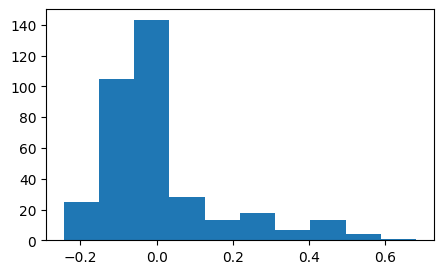

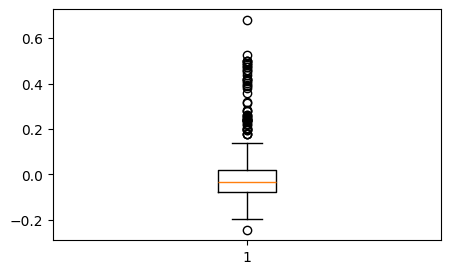

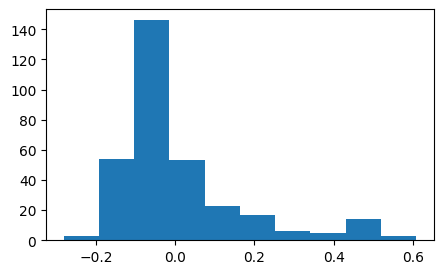

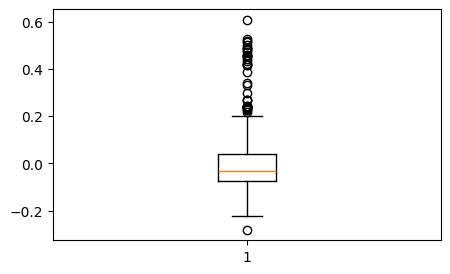

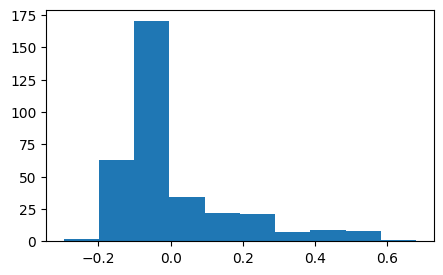

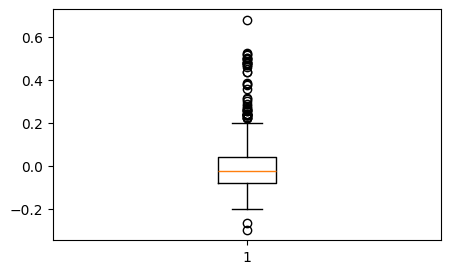

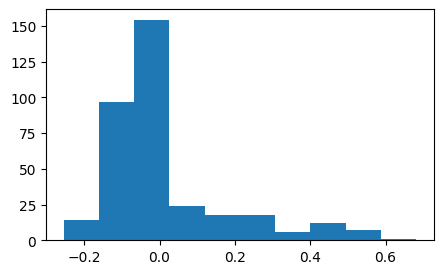

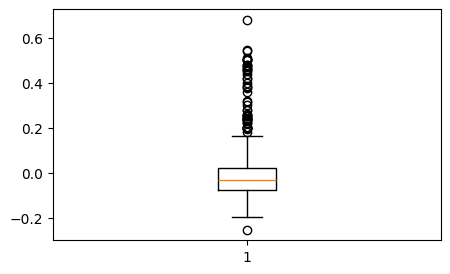

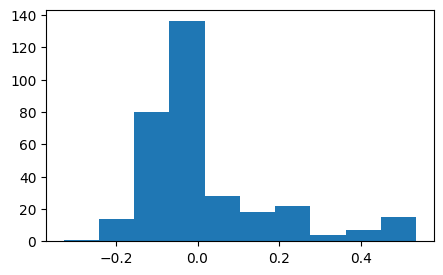

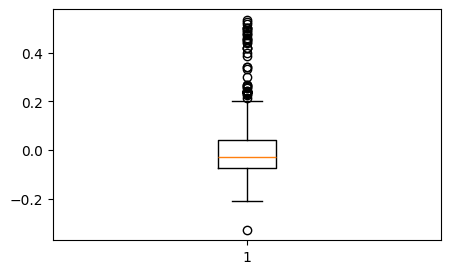

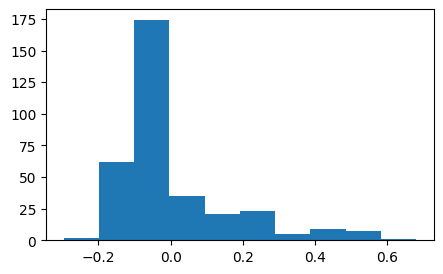

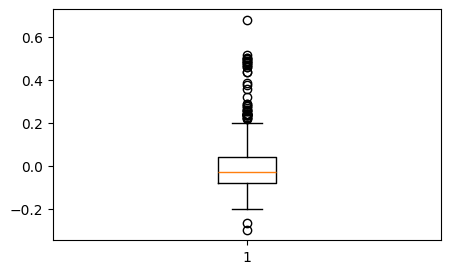

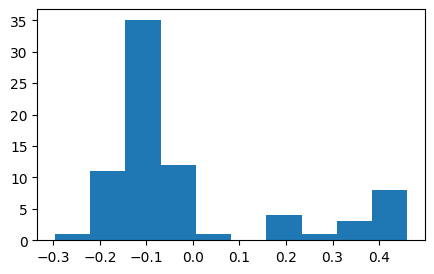

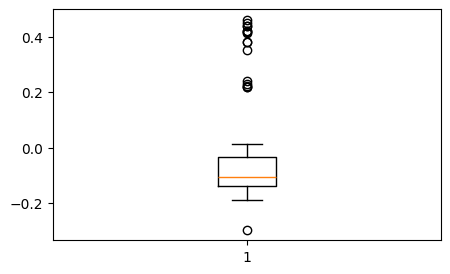

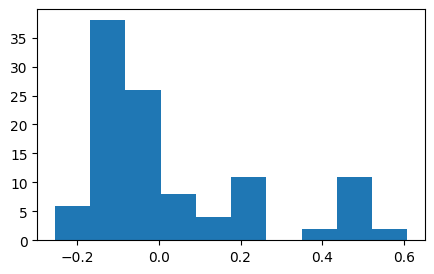

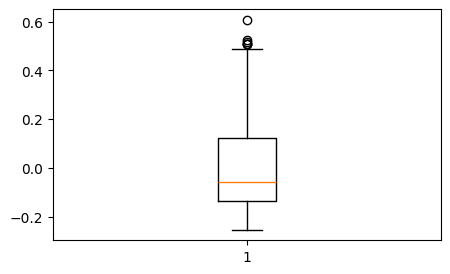

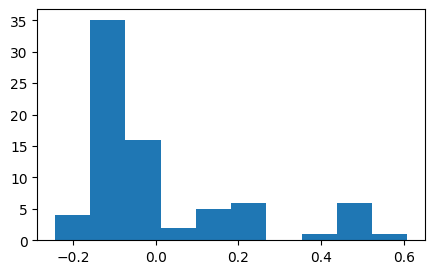

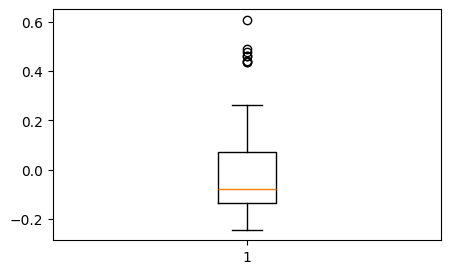

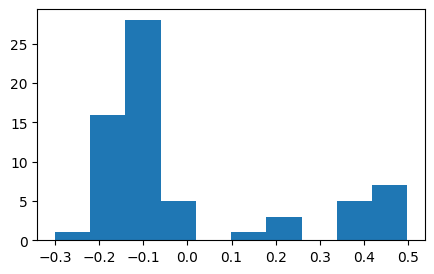

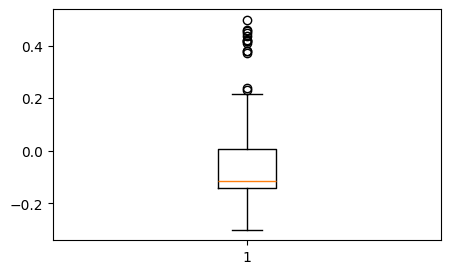

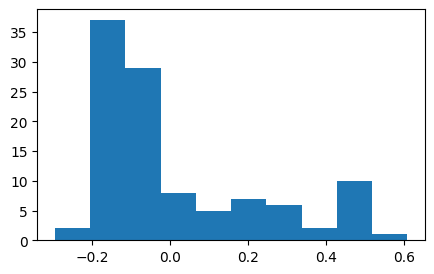

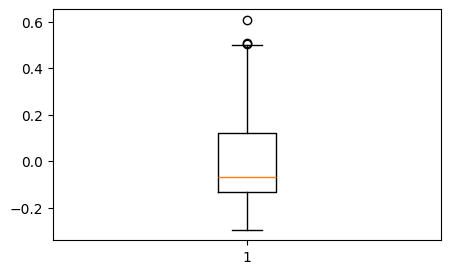

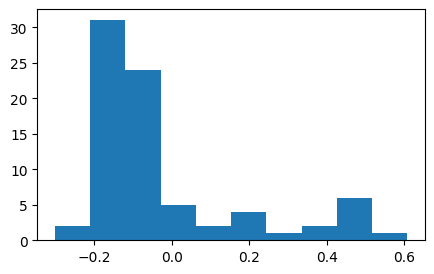

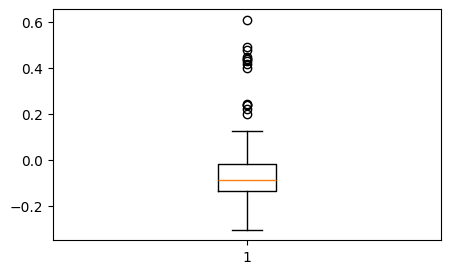

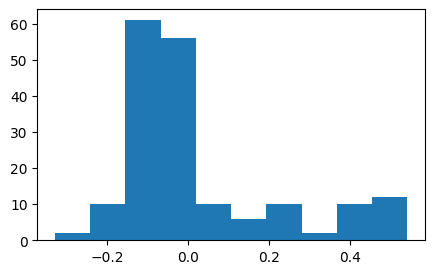

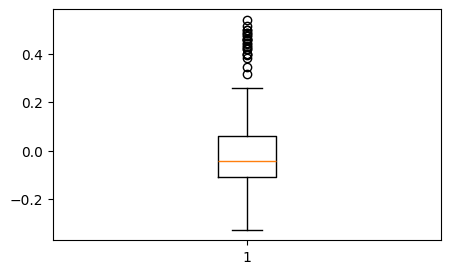

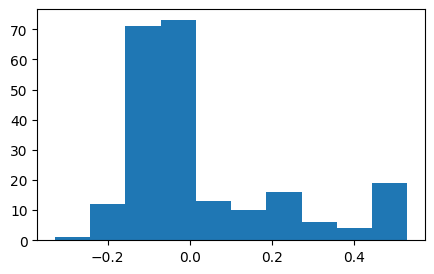

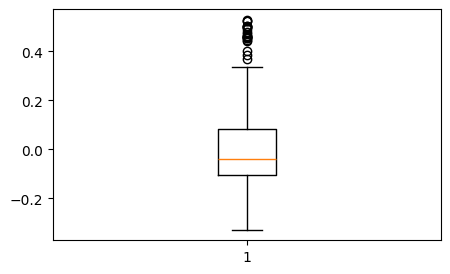

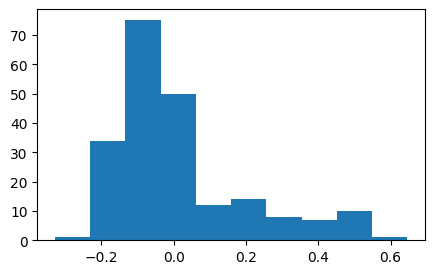

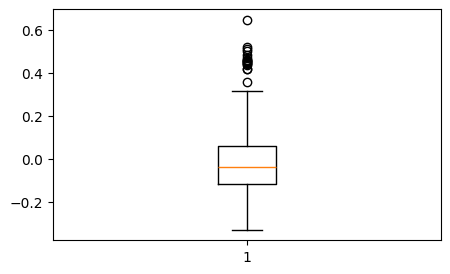

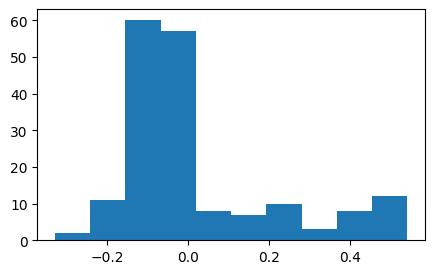

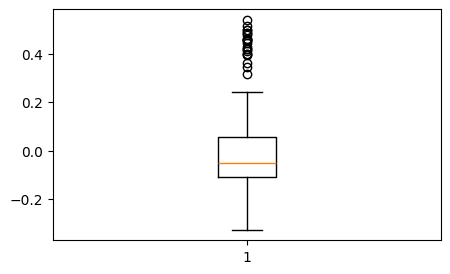

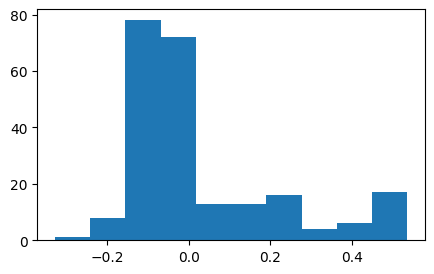

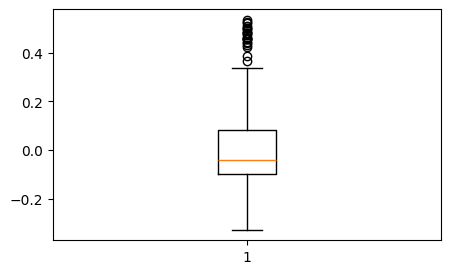

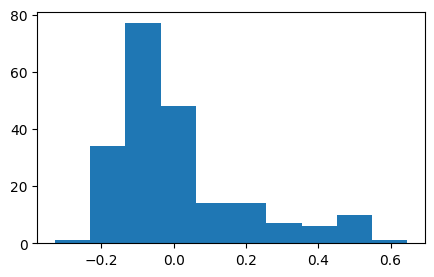

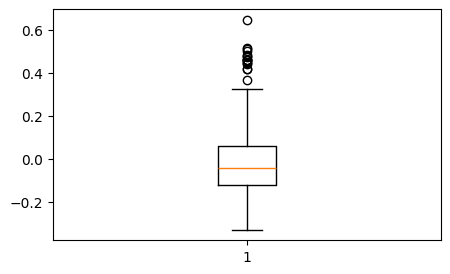

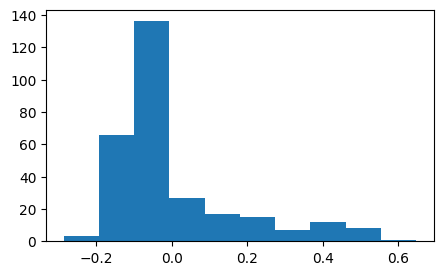

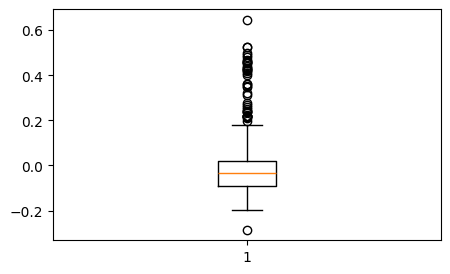

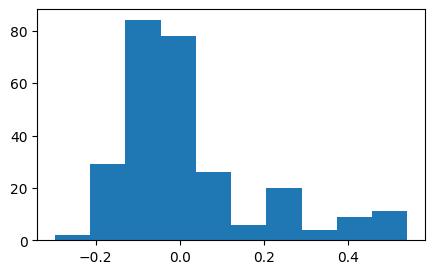

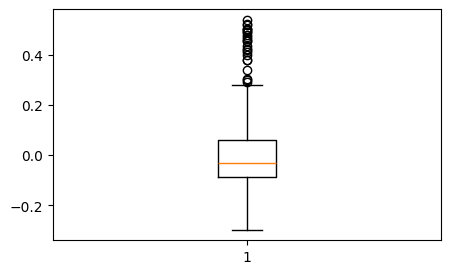

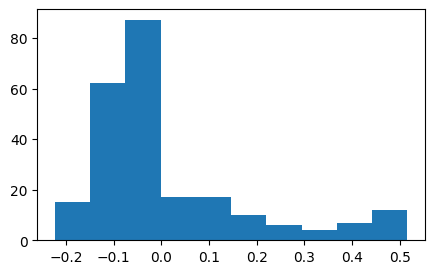

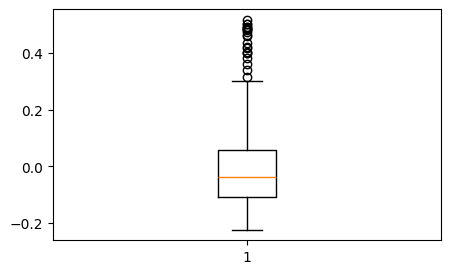

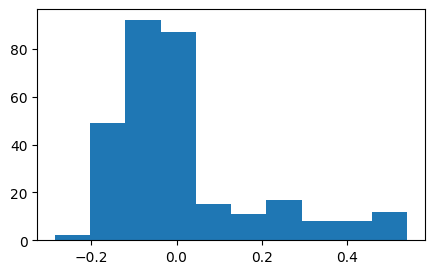

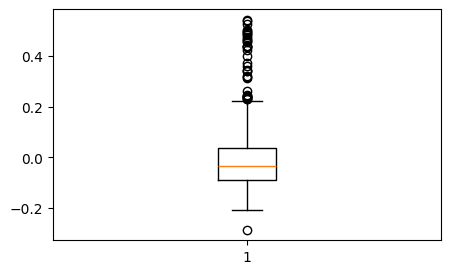

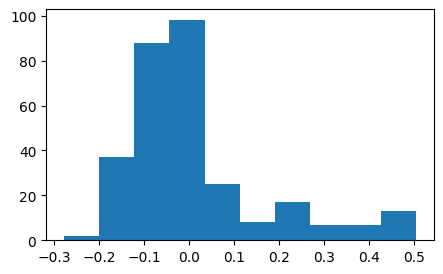

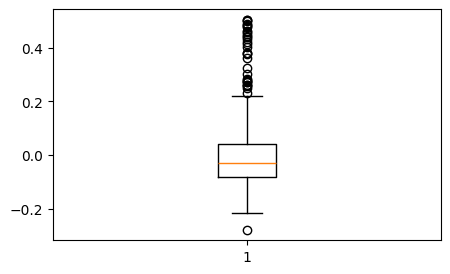

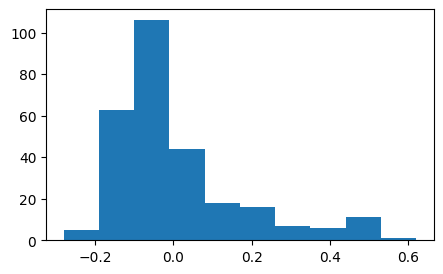

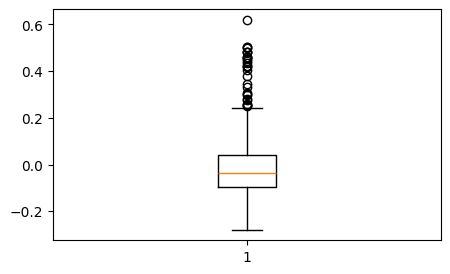

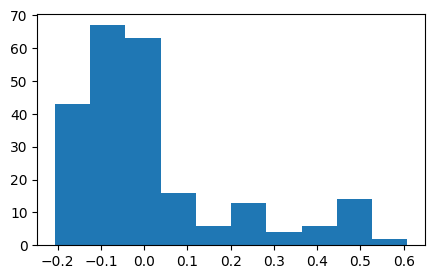

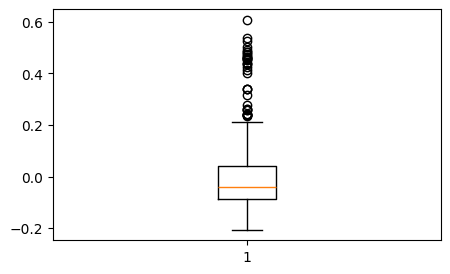

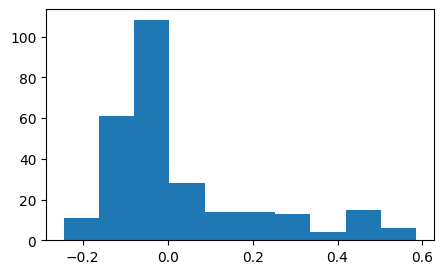

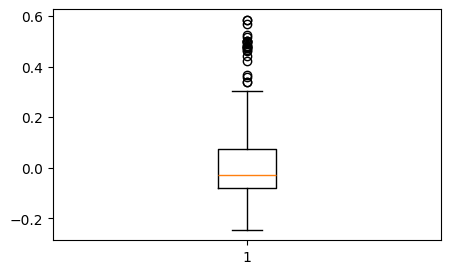

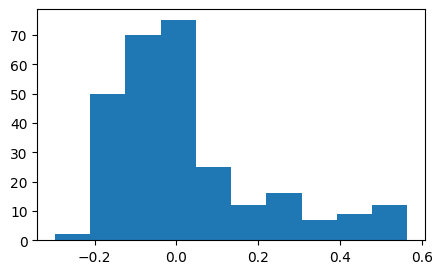

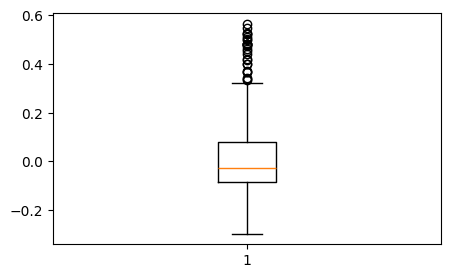

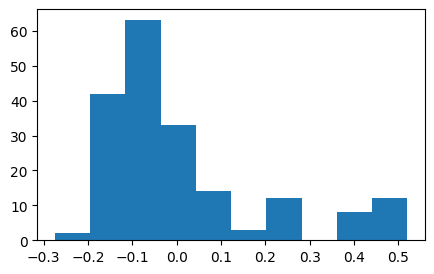

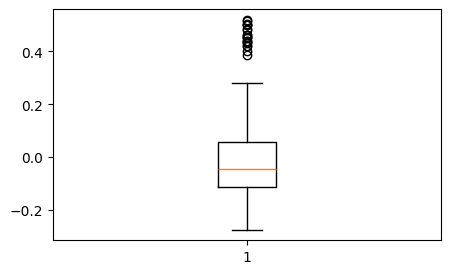

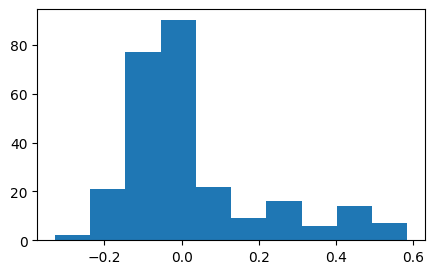

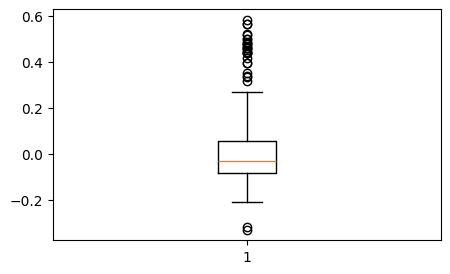

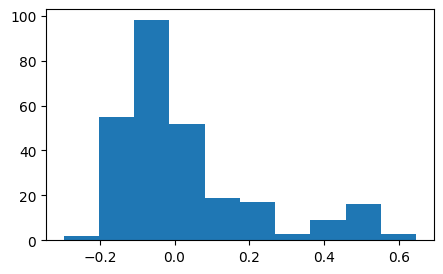

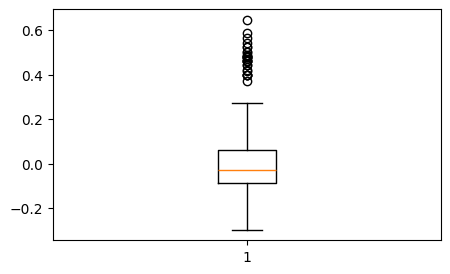

In [73]:
print_hist(rdf2)

In [ ]:
return1 = rdf2.ReturnPctList[0]
return2 = random_rdf2.ReturnPctList[5]
n_samples = len(rdf2)
combos = list(itertools.combinations(range(0, n_samples), 2))
count = 0
for i, j in combos:
    ks_stat, ks_p_val = stats.ks_2samp(rdf2.ReturnPctList[i], rdf2.ReturnPctList[j])
    # ks_stat, p_val = stats.ks_2samp(random_rdf2.ReturnPctList[i], random_rdf2.ReturnPctList[j])
    
    # if p_val < 0.05:
    #     count += 1
print(f"Number of pairs with different distributions: {count} / {len(combos)}")

In [ ]:
t_stat, t_p_val = stats.ttest_ind()

### Cleaning

## Portfolio Construction
- We actually have quite a good number of "returns" based on different techniques.
- We can utilise the backtest data to choose the techniques that will be used in the future to obtain
the best risk-adjusted return.


## Archive

### ANOVA

- Before removing outliers, 19 significantly different pairs of groups were found, observed p value is about 0.04
- After removing, 15 were found, observed p value is about 0.03


In [ ]:
from scipy.stats import f_oneway

def anova(*groups: typing.List, plot:bool=False) -> bool:
    # Calculates n F-statistic between bootstrap samples and return the list
    def bootstrap_f_stat(data_groups, n_bootstraps=1000):
        bs_f_stat_list = []
        # data_groups is all the groups that we want to compare
        
        for _ in range(n_bootstraps):
            # Get a list of randomly chosen samples for each group length
            # The length of each group might be different
            resampled_groups = [np.random.choice(group, size=len(group), replace=True) for group in data_groups]

            # Calculate the F-statistic for ith bootstrap
            # Unzip the resampled_groups to be parameters
            f_stat, p_val = f_oneway(*resampled_groups)
            bs_f_stat_list.append(f_stat)

        return bs_f_stat_list

    # Calculate the observed F-statistic
    obs_f_stat, obs_p_val = f_oneway(*groups)

    # Bootstrap the F-statistic
    bs_f_stat_list = bootstrap_f_stat(data_groups=groups)

    if plot:
        # Plotting the histogram of bootstrapped F-statistics
        plt.figure(figsize=(10, 6))
        plt.hist(bs_f_stat_list, bins=30, color='skyblue', alpha=0.7, label='Bootstrapped F-statistics')

        # Marking the observed F-statistic
        plt.axvline(obs_f_stat, color='red', linestyle='dashed', linewidth=2, label=f'Observed F-statistic ({obs_f_stat:.4f})')

        plt.title('Distribution of Bootstrapped F-statistics with Observed F-statistic')
        plt.xlabel('F-statistic')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    alpha = 0.05

    upper_quantile = np.quantile(bs_f_stat_list, 1 - alpha)

    if obs_f_stat >= upper_quantile:
        print("The difference between groups is statistically significant.")
        return True
    else:
        print("No significant difference between groups was found.")
        return False


In [ ]:
rdf.columns

In [ ]:

# Combination of 2 numbers from 0 to 29
# TODO: Change the numbers
all_combo = list(itertools.combinations(range(0, 30), 2))

count = 0

for idx in all_combo:
    # Select the 'adj_returns' for each index in idx, creating a list of pd.Series
    # Each pd.Series contains the 'adj_returns' values for one of the selected indices
    group_returns = [rdf.loc[i, 'pl_list'] for i in idx]

    # Convert the list of returns into a format suitable for the anova function
    # Assuming the anova function is designed to take multiple pd.Series as separate arguments
    stat_diff = anova(*group_returns, plot=False)

    if stat_diff: break

    count += 1

print(count / len(all_combo))

In [ ]:
print(np.mean(np.array([1,5]) > 2))

In [ ]:
def normality_test(data: typing.List):
    data3 = data
    # data2 = np.log(data)
    # pl2 = pl
    # q1 = data2.quantile(0.25)
    # q3 = data2.quantile(0.75)
    # iqr = q3 - q1

    # # Define outliers
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr

    # data3 = data2[(data2 >= lower_bound) & (data2 <= upper_bound)]

    # Normality Test
    _, p_value_normality_group1 = stats.shapiro(data3)

    print(f"Normality Test P-Values: Group1={p_value_normality_group1}")

    # Q-Q Plots for Visual Normality Check
    plt.figure(figsize=(5,3))
    sm.qqplot(data3, line ='45')
    plt.title('Group 1 Q-Q Plot')
    plt.show()

    plt.figure(figsize=(5,3))
    plt.hist(data3, bins=50, alpha=0.75, color='blue')
    plt.title('Returns Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np

def bootstrap_returns(returns, n_bootstraps=100):
    """Generate bootstrap samples for returns and calculate mean for each sample. Ustilising the Central Limit Theorem"""
    bootstrap_means = np.array([np.mean(np.random.choice(returns, size=len(returns), replace=True)) for _ in range(n_bootstraps)])
    return bootstrap_means

from scipy.stats import kstest, norm

def ks_test_with_theoretical_distribution(bootstrap_means):
    """Perform KS test comparing bootstrap means with a normal distribution."""
    # Assuming the theoretical normal distribution has the same mean and std as the bootstrap_means
    mean, std = np.mean(bootstrap_means), np.std(bootstrap_means)
    return kstest(bootstrap_means, 'norm', args=(mean, std))

def nested_ks_test_for_p_values(p_values):
    """Perform KS test to check if the given p-values are uniformly distributed."""
    return kstest(p_values, 'uniform')

# Mock data: returns for different sentiment analysis techniques
returns_data = {
    'Technique0': pl
    # 'Technique1': np.random.normal(0.05, 0.02, 1000),
    # 'Technique2': np.random.normal(0.04, 0.02, 1000),
    # Add more techniques as needed
}

n_bootstraps = 100
p_values_for_ks_tests = []

for technique, returns in returns_data.items():
    # Step 1: Bootstrap
    bootstrap_means = bootstrap_returns(returns, n_bootstraps)
    
    # Step 2: KS Test with Theoretical Distribution
    ks_stat, ks_p_value = ks_test_with_theoretical_distribution(bootstrap_means)
    print(f"KS test for {technique}: Stat={ks_stat}, P-Value={ks_p_value}")
    
    p_values_for_ks_tests.append(ks_p_value)

# Step 3: Nested-KS Test
nested_ks_stat, nested_ks_p_value = nested_ks_test_for_p_values(p_values_for_ks_tests)
print(f"Nested KS test: Stat={nested_ks_stat}, P-Value={nested_ks_p_value}")


In [ ]:
rdf.to_latex(index=False, header=True)

### Next
